<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Introduction to Machine Learning
</font>
<hr/>
<font color="#800080" size=5>
Phase 1
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2025
<br>
</font>
<font face="Times New Roman" size=4>
</font>
<hr>
<font color='red'  size=4>
<br>
</font>
<font face="Times New Roman" size=4 align=center>
Feel free to ask your questions in Telegram : @ZahraSorkhei
</font>
<br>
<hr>
</div></font>

# GMM and OOD Detection

In this notebook, you will implement a Gaussian Mixture Model (GMM) from scratch using the EM algorithm and use it for Out-of-Distribution (OOD) detection. We will start with 2D data and later extend to 3D.


## 1. Multivariate Gaussian PDF

First, we define a helper function to compute the multivariate Gaussian probability density function.

Complete the function below:


In [1]:
import numpy as np

def gaussian_pdf(x, mean, cov):
    # TODO: Compute the dimension of x
    d = x.shape[1]

    # TODO: Compute the difference between x and mean
    diff = x - mean

    # TODO: Compute inverse and determinant of covariance
    inv_cov = np.linalg.inv(cov)
    det_cov = np.linalg.det(cov)

    # TODO: Compute normalization constant
    norm_const = 1 / ((2 * np.pi) ** (d / 2) * np.sqrt(det_cov))

    # TODO: Compute exponent term
    exp_term = np.exp(-0.5 * np.sum((diff @ inv_cov) * diff, axis=1))

    return norm_const * exp_term


## 2. Implement GMM Class with EM

We will implement a GMM class with the EM algorithm.


In [2]:
class GMM:
    def __init__(self, n_components, max_iters=100, tol=1e-3):
        self.K = n_components
        self.max_iters = max_iters
        self.tol = tol

    def initialize(self, X):
        n, d = X.shape
        rng = np.random.default_rng(0)

        # TODO: Initialize means randomly from X
        self.means = rng.choice(X, size=self.K, replace=False)

        # TODO: Initialize covariance matrices
        base_cov = np.cov(X.T) + 1e-6 * np.eye(d)
        self.covs = np.stack([base_cov] * self.K)

        # TODO: Initialize mixture weights
        self.weights = np.ones(self.K) / self.K

    def e_step(self, X):
        n = X.shape[0]
        gamma = np.zeros((n, self.K))

        # TODO: Compute responsibilities
        for k in range(self.K):
          gamma[:, k] = self.weights[k] * gaussian_pdf(X, self.means[k], self.covs[k])

        gamma_sum = gamma.sum(axis=1 , keepdims=True ) + 1e-12
        # TODO: Normalize responsibilities
        gamma = gamma/ gamma_sum
        return gamma

    def m_step(self, X, gamma):
        n, d = X.shape
         # TODO: Sum responsibilities for each component
        Nk = gamma.sum(axis = 0)

        # TODO: Update weights
        self.weights = Nk / n

        # TODO: Update means
        self.means = gamma.T @ X / (Nk[:, None]+ 1e-12)
        # TODO: Update covariances
        self.covs = np.zeros_like(self.covs)
        for i in range(self.K):
          diff = X- self.means[i]
          weighted = diff.T * gamma[:, i]
          cov_k = (weighted @ diff) / (Nk[i] + 1e-12)
          self.covs[i] = cov_k + 1e-6 * np.eye(d)
    def log_likelihood(self, X):
        # TODO: Compute log-likelihood for each sample
        n = X.shape[0]
        likelihood = np.zeros(n)
        for i in range (self.K) :
          likelihood += self.weights[i] * gaussian_pdf(X, self.means[i], self.covs[i])
        ll = np.log(likelihood + 1e-12)

        return ll

    def fit(self, X):
        self.initialize(X)
        prev_ll = None

        for i in range(self.max_iters):
            # TODO: E-step
            gamma = self.e_step(X)

            # TODO: M-step
            self.m_step(X, gamma)

            # TODO: Compute mean log-likelihood
            ll = self.log_likelihood(X).mean()

            # Check for convergence
            if prev_ll is not None and abs(ll - prev_ll) < self.tol:
                break
            prev_ll = ll

        print(f"EM converged in {i+1} iterations")


## 3. Generate Toy 2D Data

Generate a 2D dataset with two Gaussian clusters (ID data) and some uniform OOD points.


In [3]:
np.random.seed(0)

# ID data (mixture of Gaussians)
N = 600
X1 = np.random.multivariate_normal([0, 0], [[0.8, 0.2], [0.2, 0.6]], N // 2)
X2 = np.random.multivariate_normal([3, 3], [[0.6, -0.1], [-0.1, 0.6]], N // 2)
X_id = np.vstack([X1, X2])

# OOD data (far away)
X_ood = np.random.uniform(low=-6, high=6, size=(200, 2))


## 4. Train GMM on ID Data

Use your implemented GMM class to fit the ID dataset.


In [4]:
# TODO: Initialize GMM with 2 components
gmm = GMM(n_components=2, max_iters=100, tol=1e-3)

# TODO: Fit GMM
gmm.fit(X_id)


EM converged in 2 iterations


## 5. OOD Detection

Compute log-likelihoods for ID and OOD points, and detect OOD points using a threshold.


In [5]:
# TODO: Compute log-likelihoods for ID and OOD data
ll_id = gmm.log_likelihood(X_id)
ll_ood = gmm.log_likelihood(X_ood)

# TODO: Set threshold
threshold = np.percentile(ll_id, 5)

# TODO: Make predictions
pred_id = (ll_id >= threshold).astype(int)
pred_ood = ( ll_ood >= threshold).astype(int)

id_false_ood_rate = np.mean(pred_id == 0)   # ID wrongly predicted as OOD
ood_detect_rate   = np.mean(pred_ood == 0)  # OOD correctly detected

print("Threshold:", threshold)
print("ID predicted OOD rate:", 1 - pred_id.mean())
print("OOD detected rate:", 1 - pred_ood.mean())



Threshold: -4.8445118708257695
ID predicted OOD rate: 0.050000000000000044
OOD detected rate: 0.815


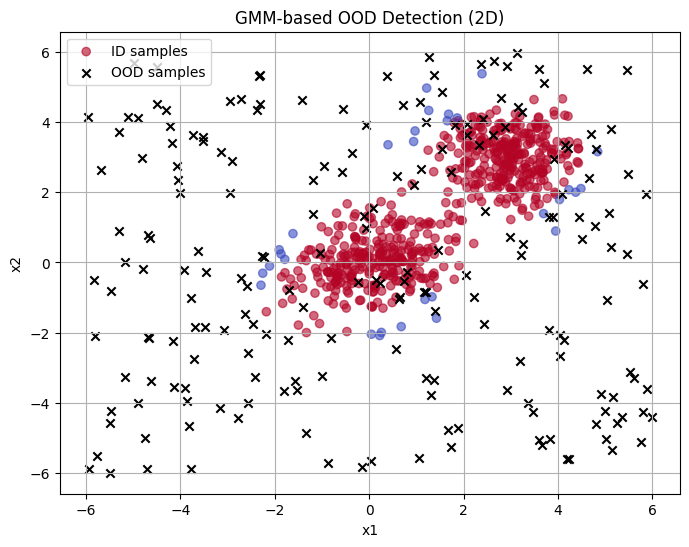

In [6]:
import matplotlib.pyplot as plt
# =========================
# Visualization
# =========================
plt.figure(figsize=(8, 6))
plt.scatter(X_id[:, 0], X_id[:, 1],
            c=pred_id, cmap="coolwarm", alpha=0.6, label="ID samples")
plt.scatter(X_ood[:, 0], X_ood[:, 1],
            c="black", marker="x", label="OOD samples")
plt.legend()
plt.title("GMM-based OOD Detection (2D)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(True)
plt.show()

# GMM Image Segmentation

In this notebook, you will apply Gaussian Mixture Models (GMM) with EM algorithm to perform clustering-based segmentation on color images. You will work with 3-channel images (RGB).

## 1. Gaussian PDF Function

Complete the multivariate Gaussian PDF function. This function will be used in the EM algorithm.


In [7]:
import numpy as np

def gaussian_pdf(x, mean, cov):

    x = np.asarray(x)
    mean = np.asarray(mean)
    cov = np.asarray(cov)

    if x.ndim == 1:
        x2 = x[None, :]
        squeeze = True
    else:
        x2 = x
        squeeze = False

    d = x2.shape[1]
    diff = x2 - mean

    # numerical stability
    cov = cov + 1e-6 * np.eye(d)

    inv_cov = np.linalg.inv(cov)
    det_cov = np.linalg.det(cov)

    norm_const = 1.0 / np.sqrt(((2 * np.pi) ** d) * det_cov)
    # exponent for each sample
    quad = np.einsum("ni,ij,nj->n", diff, inv_cov, diff)
    exp_term = np.exp(-0.5 * quad)

    out = norm_const * exp_term
    return out[0] if squeeze else out


## 2. Implement GMM Class with EM

Fill in the missing parts for the GMM class.


In [8]:
class GMM:
    def __init__(self, n_components, max_iters=40, tol=1e-3):
        self.K = n_components
        self.max_iters = max_iters
        self.tol = tol

    def initialize(self, X):
        n, d = X.shape
        rng = np.random.default_rng()

        self.means = rng.choice(X, size=self.K, replace=False)

        base_cov = np.cov(X.T) + 1e-6 * np.eye(d)
        self.covs = np.stack([base_cov] * self.K)

        self.weights = np.ones(self.K) / self.K

    def e_step(self, X):
        n = X.shape[0]
        gamma = np.zeros((n, self.K))

        for k in range(self.K):
            gamma[:, k] = self.weights[k] * gaussian_pdf(
                X, self.means[k], self.covs[k]
            )

        gamma_sum = gamma.sum(axis=1, keepdims=True) + 1e-12
        gamma = gamma / gamma_sum
        return gamma

    def m_step(self, X, gamma):
        n, d = X.shape
        Nk = gamma.sum(axis=0) + 1e-12

        self.weights = Nk / n
        self.means = (gamma.T @ X) / Nk[:, None]

        self.covs = np.zeros((self.K, d, d))
        for k in range(self.K):
            diff = X - self.means[k]
            weighted = diff.T * gamma[:, k]
            self.covs[k] = (weighted @ diff) / Nk[k]
            self.covs[k] += 1e-6 * np.eye(d)

    def fit(self, X):
        self.initialize(X)
        prev_ll = None

        for _ in range(self.max_iters):
            gamma = self.e_step(X)
            self.m_step(X, gamma)

            ll = np.log(
                sum(
                    self.weights[k]
                    * gaussian_pdf(X, self.means[k], self.covs[k])
                    for k in range(self.K)
                )
                + 1e-12
            ).mean()

            if prev_ll is not None and abs(ll - prev_ll) < self.tol:
                break
            prev_ll = ll

        return self

    def predict(self, X):
        gamma = self.e_step(X)
        return np.argmax(gamma, axis=1)


## 3. Segment Image Function

In [9]:
from skimage.transform import resize
from skimage.color import gray2rgb
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

def segment_image(image, K, title):
      """
      Segment a color image using GMM clustering.

      image : ndarray
          Input image (H x W x 3 or grayscale)
      K : int
          Number of clusters
      title : str
          Title for the original image

      """

      # TODO: Resize the image to 256x256
      image = resize(image, (256, 256), preserve_range=True, anti_aliasing=True).astype(np.float32)

       # TODO: If grayscale, convert to 3-channel RGB
      if image.ndim == 2:
          image = gray2rgb(image)


      H, W, _ = image.shape
      if image.max() > 1.0:
          image /= 255.0
      # TODO: Reshape image to N x 3 for GMM
      X = image.reshape(-1, 3)

      # TODO: Initialize GMM and fit to pixel data
      gmm = GMM(n_components=K, max_iters=40, tol=1e-3)
      # TODO: Fit GMM
      gmm.fit(X)

      # TODO: Predict cluster labels and reshape labels back to H x W
      labels = gmm.predict(X)
      label_map = labels.reshape(H, W)


      # fixed colormap
      cmap = plt.get_cmap("tab10", K)

      # TODO: Create legend handles for each cluster
      legend_elements = [mpatches.Patch(color=cmap(i), label=f"Cluster {i}")for i in range(K)]

      plt.figure(figsize=(10, 4))

      plt.subplot(1, 2, 1)
      if image.ndim ==2:
        image_disp = (image - image.min()) / (image.max() - image.min() + 1e-12)
        plt.imshow(image_disp, cmap="gray")
      else:
        image_disp = image
        if image_disp.max() > 1.0:
          image_disp /= 255.0
        plt.imshow(image_disp)
      plt.title(f"Original – {title}")
      plt.axis("off")

      plt.subplot(1, 2, 2)
      plt.imshow(label_map, cmap=cmap)
      plt.title("GMM Segmentation (Labels)")
      plt.axis("off")
      plt.legend(handles=legend_elements,
                bbox_to_anchor=(1.05, 1),
                loc="upper left",
                borderaxespad=0.)

      plt.tight_layout()
      plt.show()


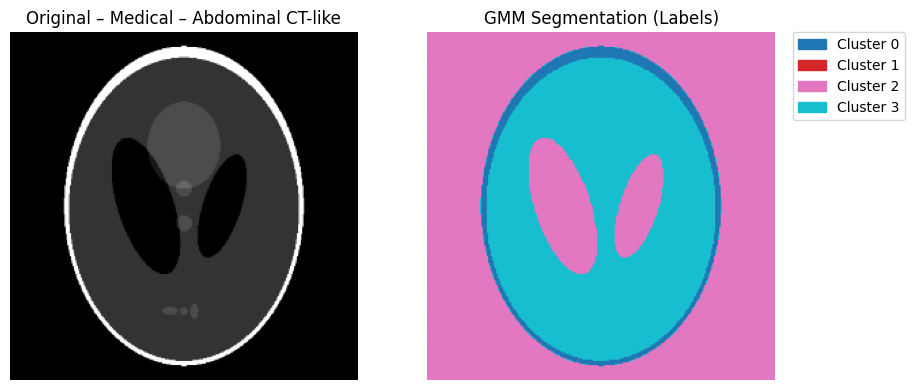

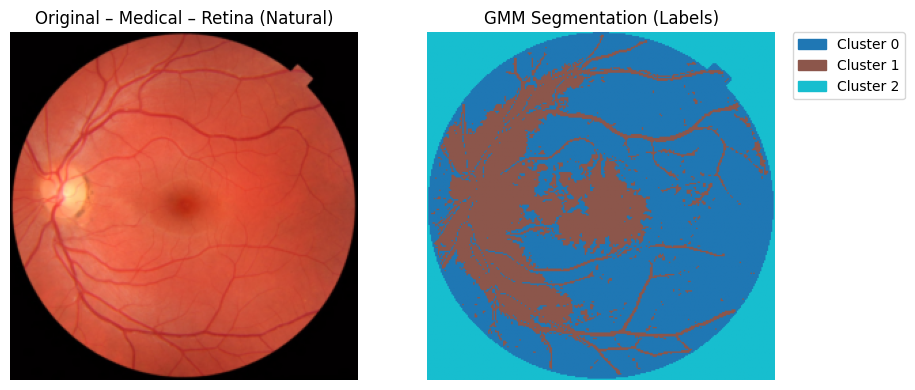

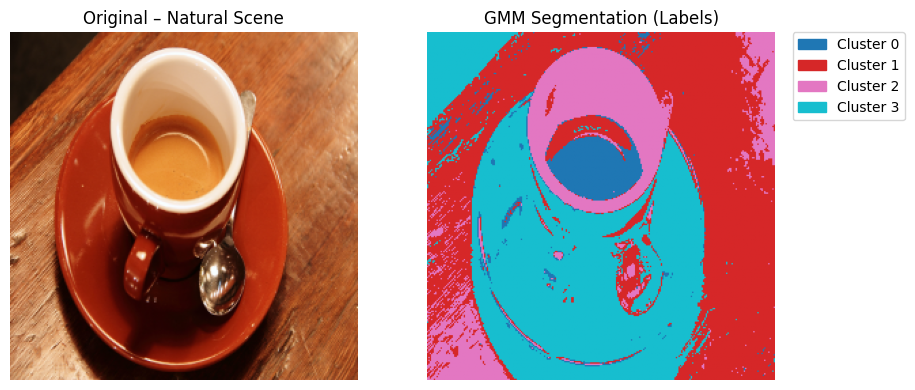

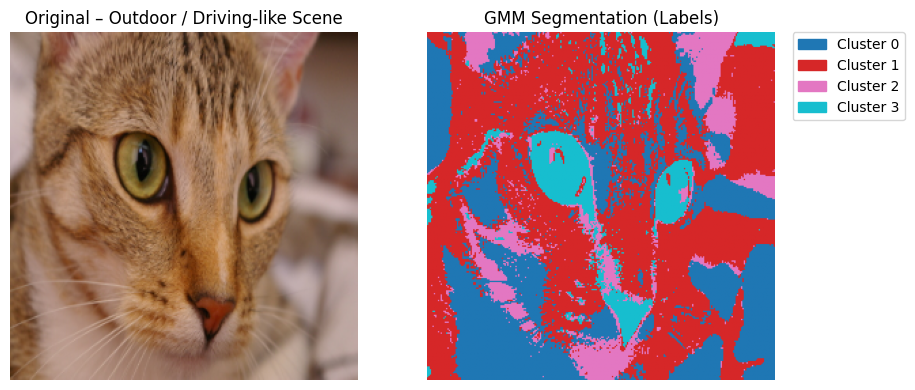

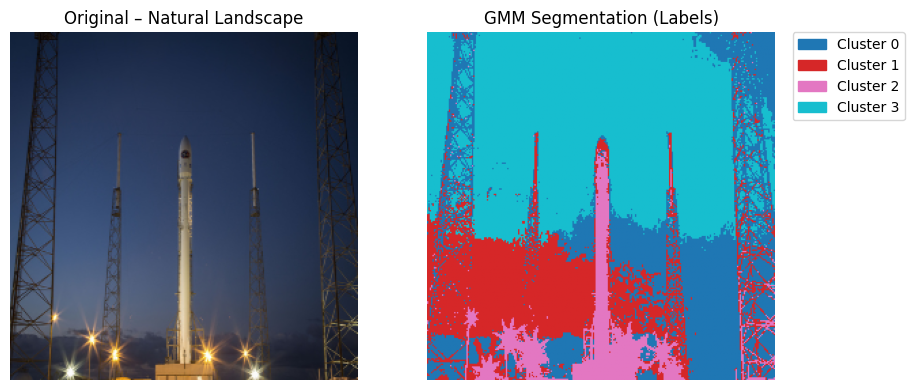

In [10]:
# =========================
# Run experiments
# =========================
from skimage import data
segment_image(data.shepp_logan_phantom(), 4,
              "Medical – Abdominal CT-like")

segment_image(data.retina(),  K=3, title="Medical – Retina (Natural)")

segment_image(data.coffee(), 4,
              "Natural Scene")

segment_image(data.chelsea(), 4,
              "Outdoor / Driving-like Scene")

segment_image(data.rocket(), 4,
              "Natural Landscape")
